In [6]:
import os
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from pycocotools.coco import COCO
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# === Paths ===
data_dir = "D:\Image Captioning And Segmentation\COCO2017"  # Replace with your COCO root directory
train_img_dir = os.path.join(data_dir, 'image/train2017')
val_img_dir = os.path.join(data_dir, 'image/val2017')
train_ann_file = os.path.join(data_dir, 'annotations/captions_train2017.json')
val_ann_file = os.path.join(data_dir, 'annotations/captions_val2017.json')

<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\abhay\AppData\Local\Temp\ipykernel_8260\667087829.py:2: SyntaxWarning: invalid escape sequence '\I'
  data_dir = "D:\Image Captioning And Segmentation\COCO2017"  # Replace with your COCO root directory


In [8]:
# === Vocabulary Builder ===
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}

    def build_vocab(self, sentence_list):
        freq = {}
        idx = 4
        for sentence in sentence_list:
            words = sentence.lower().split()  # Fallback if nltk punkt fails
            for word in words:
                freq[word] = freq.get(word, 0) + 1
                if freq[word] == self.freq_threshold:
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in text.lower().split()]

In [9]:
# === COCO Dataset Loader ===
class CocoCaptionDataset(Dataset):
    def __init__(self, root, ann_file, vocab, transform=None):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        ann_id = self.ids[index]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        img_path = os.path.join(self.root, self.coco.loadImgs(img_id)[0]['file_name'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        numericalized = [self.vocab.word2idx['<START>']] + self.vocab.numericalize(caption) + [self.vocab.word2idx['<END>']]
        return image, torch.tensor(numericalized), img_path

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, x):
        with torch.no_grad():
            x = self.resnet(x)  # [batch_size, 2048, 1, 1]
        x = x.view(x.size(0), -1)  # [batch_size, 2048]
        x = self.fc(x)
        x = self.bn(x)
        return x

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        return self.linear(hiddens)

In [11]:
# === Training Setup ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [12]:
# Step 1: Build vocab from training captions
coco_train = COCO(train_ann_file)
all_captions = [ann['caption'] for ann in coco_train.anns.values()]
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab(all_captions)

train_dataset = CocoCaptionDataset(train_img_dir, train_ann_file, vocab, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [13]:
# Step 2: Model init
embed_size = 256
hidden_size = 512
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab.word2idx))
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.fc.parameters()), lr=1e-3)

d:\Image Captioning And Segmentation\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Image Captioning And Segmentation\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Step 3: Train loop (mini example)
for epoch in range(0):  # Replace 1 with 10+ epochs later
    for images, captions, _ in train_loader:
        images = torch.stack(images)
        lengths = [len(cap) for cap in captions]
        captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])

        features = encoder(images)
        outputs = decoder(features, captions)  # Shape: [B, T+1, V]
        targets = captions[:, 1:]              # Shape: [B, T]

        # Truncate outputs to match targets
        outputs = outputs[:, :targets.size(1), :]  # Shape: [B, T, V]

        loss = criterion(outputs.reshape(-1, outputs.size(2)), targets.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

In [15]:
def __getitem__(self, index):
    ann_id = self.ids[index]
    caption = self.coco.anns[ann_id]['caption']
    img_id = self.coco.anns[ann_id]['image_id']
    img_path = os.path.join(self.root, self.coco.loadImgs(img_id)[0]['file_name'])

    image = Image.open(img_path).convert("RGB")
    if self.transform:
        image = self.transform(image)

    numericalized = [self.vocab.word2idx['<START>']] + self.vocab.numericalize(caption) + [self.vocab.word2idx['<END>']]

    return image, torch.tensor(numericalized), caption, img_path  # ✅ now returns 4 items


In [16]:
# === Inference (Captioning + Segmentation) ===
def generate_caption(encoder, decoder, image_tensor, vocab, max_len=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        feature = encoder(image_tensor)
        caption = [vocab.word2idx['<START>']]
        for _ in range(max_len):
            cap_tensor = torch.tensor([caption]).to(image_tensor.device)
            output = decoder(feature, cap_tensor)
            _, pred = output[:, -1, :].max(1)
            caption.append(pred.item())
            if pred.item() == vocab.word2idx['<END>']:
                break
    return ' '.join([vocab.idx2word.get(idx, '<unk>') for idx in caption[1:-1]])

In [17]:
# === Segmentation Model ===
seg_model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
seg_model.eval()

d:\Image Captioning And Segmentation\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [18]:
def get_coco_labels(json_path):
    from pycocotools.coco import COCO
    coco = COCO(json_path)
    cats = coco.loadCats(coco.getCatIds())
    labels = ['__background__'] + [cat['name'] for cat in cats]
    return labels

def visualize(image_path, threshold=0.5):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from torchvision.transforms.functional import to_tensor
    from torchvision import transforms
    import numpy as np
    from PIL import Image
    import torch

    # Load image
    img = Image.open(image_path).convert("RGB")

    # Prepare for caption generation
    transform_caption = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img_tensor_caption = transform_caption(img).unsqueeze(0)

    # Prepare for segmentation
    img_tensor_seg = to_tensor(img).unsqueeze(0)

    # Generate caption
    caption = generate_caption(encoder, decoder, img_tensor_caption, vocab)

    # Generate segmentation
    with torch.no_grad():
        preds = seg_model(img_tensor_seg)[0]

    # 🔄 Load COCO labels dynamically from annotation JSON
    coco_labels_path = "D:/Image Captioning And Segmentation/COCO2017/annotations/instances_val2017.json"
    COCO_INSTANCE_CATEGORY_NAMES = get_coco_labels(coco_labels_path)

    # Convert image for visualization
    img_np = np.array(img)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img_np)

    # Draw each prediction
    for i, (box, label, score) in enumerate(zip(preds['boxes'], preds['labels'], preds['scores'])):
        if score < threshold:
            continue

        x1, y1, x2, y2 = map(int, box.tolist())
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]
        display_text = f"id:{i+1} {class_name} {score:.2f}"

        # Draw bounding box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)

        # Draw label above the bounding box
        ax.text(x1, y1 - 10, display_text,
                fontsize=10, color='white',
                bbox=dict(facecolor='orange', alpha=0.8))

        # Optional mask overlay
        if 'masks' in preds:
            mask = preds['masks'][i, 0].mul(255).byte().cpu().numpy()
            rgba_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)
            rgba_mask[mask > 127] = [255, 165, 0, 100]  # RGBA for orange mask
            ax.imshow(rgba_mask)

    ax.axis("off")
    plt.title("Image Captioning + Segmentation")
    plt.tight_layout()
    plt.show()


In [24]:
def live_caption_and_segmentation(encoder, decoder, vocab, seg_model, threshold=0.5):
    import cv2
    from torchvision.transforms.functional import to_tensor

    # Full COCO class list with 91 entries (index matches label IDs)
    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
        'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
        'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
        'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
        'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A',
        'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
        'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
        'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]


    cap = cv2.VideoCapture(0)
    transform_caption = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    print("Press 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to PIL image
        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Prepare caption input
        img_tensor_caption = transform_caption(pil_img).unsqueeze(0)
        caption = generate_caption(encoder, decoder, img_tensor_caption, vocab)

        # Prepare segmentation input
        img_tensor_seg = to_tensor(pil_img).unsqueeze(0)
        with torch.no_grad():
            preds = seg_model(img_tensor_seg)[0]

        # Draw predictions
        for i in range(len(preds["boxes"])):
            score = preds["scores"][i].item()
            if score > threshold:
                box = preds["boxes"][i].cpu().numpy().astype(int)
                label = preds["labels"][i].item()

                # Prevent index error
                if label < len(COCO_INSTANCE_CATEGORY_NAMES):
                    class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
                else:
                    class_name = "Unknown"

                x1, y1, x2, y2 = box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, class_name, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Draw caption
        cv2.putText(frame, f"Caption: {caption}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Show frame
        cv2.imshow("Live Caption + Segmentation", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


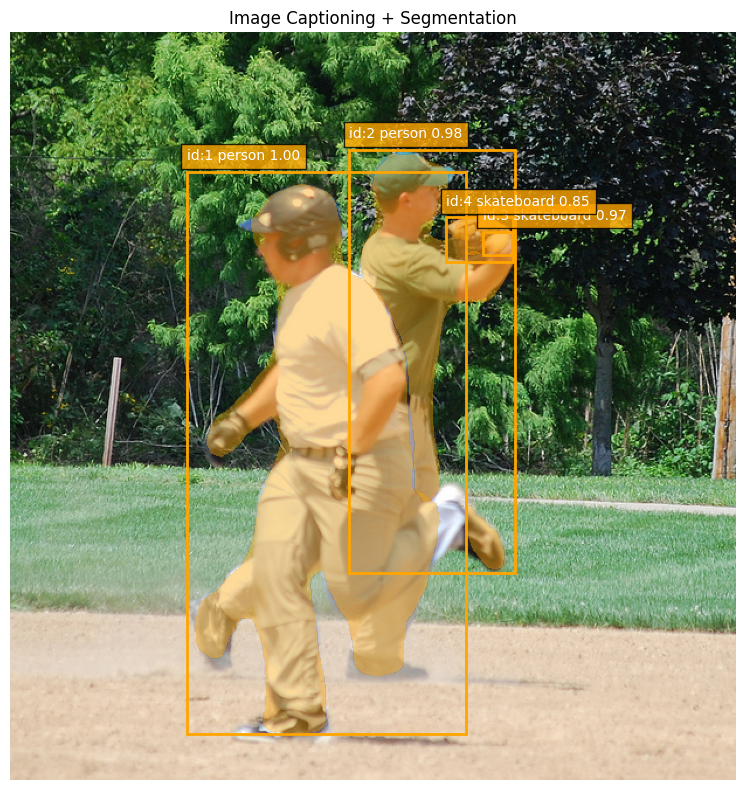

In [25]:
visualize(r"D:\Image Captioning And Segmentation\COCO2017\image\val2017\000000000872.jpg")

In [26]:
# Ensure models are on eval mode
encoder.eval()
decoder.eval()
seg_model.eval()

# Start webcam caption + segmentation
live_caption_and_segmentation(encoder, decoder, vocab, seg_model)


Press 'q' to quit.
